# Quickstart: Building a GenAI powered Semantic Data Model with Intugle

This quickstart shows you how to use Intugle’s open-source library to transform fragmented datasets into a connected semantic model. The semantic model captures profiling, relationships, and business meaning of your data — making it instantly usable for exploration, search, and data product creation.

**What is a Semantic Model?**

A semantic model is an intelligent knowledge graph of your data. It connects tables, discovers relationships, and enriches them with business glossaries — so both data teams and business users can query with clarity, not complexity.

**Who is this for?**

*   **Data Engineers & Architects** often spend weeks manually profiling, classifying, and stitching together fragmented data assets. With Intugle, they can automate this process end-to-end, uncovering meaningful links and relationships to instantly generate a connected semantic layer.
*   **Data Analysts & Scientists** spend endless hours on data readiness and preparation before they can even start the real analysis. Intugle accelerates this by providing contextual intelligence, automatically generating SQL and reusable data products enriched with relationships and business meaning.
*   **Business Analysts & Decision Makers** are slowed down by constant dependence on technical teams for answers. Intugle removes this bottleneck by enabling natural language queries and semantic search, giving them trusted insights on demand.

**In this notebook, you will learn how to:**

*   **Generate Semantic Model** → The unified layer that transforms fragmented datasets, creating the foundation for connected intelligence.
    *   **1.1 Profile and classify data** → Analyze your data sources to understand their structure, data types, and other characteristics.
    *   **1.2 Discover links & relationships among data** → Reveal meaningful connections (PK & FK) across fragmented tables.
    *   **1.3 Generate a business glossary** → Create business-friendly terms and use them to query data with context.
    *   **1.4 Enable Semantic search** → Intelligent search that understands meaning, not just keywords—making data more accessible across both technical and business users.
    *   **1.5 Visualize semantic model** → Get access to enriched metadata of the semantic model and visualize your data and relationships.
*   **Build Unified Data Products** → Simply pick the attributes across your data tables, and let the toolkit auto-generate queries with all the required joins, transformations, and aggregations using the semantic layer. When executed, these queries produce reusable data products.

Before you start, make sure you install the **Intugle Data Tools**:

In [ ]:
%pip install intugle

## 1. LLM Configuration

Before running the project, you need to configure a Large Language Model (LLM). This is used for tasks like generating business glossaries and predicting links between tables. For the semantic search feature, you will also need to set up Qdrant and provide an OpenAI API key. For detailed setup instructions, please refer to the [README.md](README.md) file.

You can configure the necessary services by setting the following environment variables:

*   `LLM_PROVIDER`: The LLM provider and model to use (e.g., `openai:gpt-3.5-turbo`). The format follows langchain's format for initializing chat models. Checkout how to specify your model [here](https://python.langchain.com/docs/integrations/chat/)
*   `API_KEY`: Your API key for the LLM provider. The exact name of the variable may vary from provider to provider (e.g., `OPENAI_API_KEY`, `ANTHROPIC_API_KEY`).
*   `QDRANT_URL`: The URL of your Qdrant instance (e.g., `http://localhost:6333`).
*   `QDRANT_API_KEY`: Your API key for the Qdrant instance, if authorization is enabled.
*   `EMBEDDING_MODEL_NAME`: The embedding model to use. The format follows LangChain's conventions for initializing embedding models (e.g., `openai:ada`, `azure_openai:ada`).
*   `OPENAI_API_KEY`: Your OpenAI API key, required if you are using an OpenAI embedding model.
*   `AZURE_OPENAI_API_KEY`, `AZURE_OPENAI_ENDPOINT`, `OPENAI_API_VERSION`: Your Azure OpenAI credentials, required if you are using an Azure OpenAI embedding model.

Here's an example of how to set these variables in your environment:

```bash
export LLM_PROVIDER="openai:gpt-3.5-turbo"
export OPENAI_API_KEY="your-openai-api-key"
```
Alternatively, you can set them in the notebook like this:

In [ ]:
import os

os.environ["LLM_PROVIDER"] = "openai:gpt-3.5-turbo"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"  # Replace with your actual key

# Semantic Search Configuration (Optional)
os.environ["QDRANT_URL"] = "http://localhost:6333"
os.environ["QDRANT_API_KEY"] = "" # if authorization is used
os.environ["EMBEDDING_MODEL_NAME"] = "openai:ada"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"

# For Azure OpenAI models
os.environ["EMBEDDING_MODEL_NAME"] = "azure_openai:ada"
os.environ["AZURE_OPENAI_API_KEY"] = "your-azure-openai-api-key"
os.environ["AZURE_OPENAI_ENDPOINT"] = "your-azure-openai-endpoint"
os.environ["OPENAI_API_VERSION"] = "your-openai-api-version"



> Currently the langchain packages for OpenAI, Anthropic and Gemini is installed by default. For additional models, make sure you have the integration packages installed. E.g. you should have langchain-deepseek installed to use a DeepSeek model. You can get these packages here: [LangChain Chat Models](https://python.langchain.com/docs/integrations/chat/)

## 2. Building the Semantic Model

The `SemanticModel` is the entry point for building your semantic layer. It takes a dictionary of datasets as input and performs the following steps:

1.  **Data Profiling:** Calculates statistics for each column, such as distinct count, uniqueness, and completeness.
2.  **Datatype Identification:** Identifies the data type of each column (e.g., integer, string, datetime).
3.  **Key Identification:** Identifies potential primary keys.
4.  **Glossary Generation:** Generates a business glossary for each column using an LLM.
5.  **Link Prediction:** Predicts the relationships (foreign keys) between tables.

Let's start by defining the datasets we want to use. The path shown below can be a local file path or a remote URL.

In [2]:
def generate_config(table_name: str) -> str:
    """Append the base URL to the table name."""
    return {
        "path": f"./sample_data/sports_media/{table_name}.csv",
        "type": "csv",
    }


table_names = [
"ads",
"availability_region",
"bio",
"broadcasters",
"campaigns_audience",
"campaigns",
"career_stats",
"cdns",
"colors",
"contract_details",
"devices",
"engagement",
"info",
"injury_details",
"interactions",
"license_info",
"locations",
"matches",
"match_sponsor",
"metadata",
"payment_hist",
"perf_metrics",
"players_social_media_handles",
"preferred_players",
"preferred_sports",
"preferred_teams",
"scores",
"sponosred_campaign",
"sponsor_contact",
"sponsor_details",
"subscriptions",
"subs_pmt",
"target_audience",
"team_bio",
"team_social",
"teams_playing",
"team_sponsor",
"viewer_details",
"viewerships",
"weather",
]

datasets = {table: generate_config(table) for table in table_names}

Now, let's use the `SemanticModel` to build our semantic layer:

> The `domain` parameter helps the LLM generate a more contextual business glossary. It specifies the industry domain that the dataset belongs to (e.g., "Healthcare", "Finance", "E-commerce").

In [3]:
from intugle import SemanticModel

# Initialize the semantic model
sm = SemanticModel(datasets, domain="Sports Media Company")

# Run the prediction
sm.build()

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "Source" shadows an attribute in parent "BaseResource"
  warnings.warn(


ads loaded
availability_region loaded
bio loaded
broadcasters loaded
campaigns_audience loaded
campaigns loaded
career_stats loaded
cdns loaded
colors loaded
contract_details loaded
devices loaded
engagement loaded
info loaded
injury_details loaded
interactions loaded
license_info loaded
locations loaded
matches loaded
match_sponsor loaded
metadata loaded
payment_hist loaded
perf_metrics loaded
players_social_media_handles loaded
preferred_players loaded
preferred_sports loaded
preferred_teams loaded
scores loaded
sponosred_campaign loaded
sponsor_contact loaded
sponsor_details loaded
subscriptions loaded
subs_pmt loaded
target_audience loaded
team_bio loaded
team_social loaded
teams_playing loaded
team_sponsor loaded
viewer_details loaded
viewerships loaded
weather loaded


Starting profiling and key identification stage...

Processing dataset: ads

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] ads:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] ads: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Processing dataset: availability_region

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Processing dataset: bio

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] bio:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] bio: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Processing dataset: broadcasters

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] broadcasters:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] broadcasters: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Processing dataset: campaigns_audience

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] campaigns_audience:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] campaigns_audience: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Processing dataset: campaigns

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] campaigns:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] campaigns: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Processing dataset: career_stats

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] career_stats:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] career_stats: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Processing dataset: cdns

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] cdns:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] cdns: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Processing dataset: colors

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Processing dataset: contract_details

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] contract_details:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] contract_details: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Processing dataset: devices

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] devices:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] devices: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Processing dataset: engagement

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] engagement:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] engagement: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Processing dataset: info

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] info:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] info: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Processing dataset: injury_details

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] injury_details:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] injury_details: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Processing dataset: interactions

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] interactions:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] interactions: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Processing dataset: license_info

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] license_info:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] license_info: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Processing dataset: locations

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] locations:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] locations: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Processing dataset: matches

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] matches:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] matches: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Processing dataset: match_sponsor

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] match_sponsor:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] match_sponsor: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Processing dataset: metadata

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] metadata:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] metadata: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Processing dataset: payment_hist

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] payment_hist:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] payment_hist: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Processing dataset: perf_metrics

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] perf_metrics:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] perf_metrics: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Processing dataset: players_social_media_handles

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] players_social_media_handles:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] players_social_media_handles: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Processing dataset: preferred_players

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Processing dataset: preferred_sports

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Processing dataset: preferred_teams

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Processing dataset: scores

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] scores:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] scores: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Processing dataset: sponosred_campaign

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Processing dataset: sponsor_contact

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] sponsor_contact:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] sponsor_contact: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Processing dataset: sponsor_details

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] sponsor_details:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] sponsor_details: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Processing dataset: subscriptions

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] subscriptions:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] subscriptions: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Processing dataset: subs_pmt

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] subs_pmt:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] subs_pmt: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Processing dataset: target_audience

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] target_audience:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] target_audience: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Processing dataset: team_bio

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] team_bio:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] team_bio: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Processing dataset: team_social

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] team_social:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] team_social: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Processing dataset: teams_playing

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] teams_playing:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] teams_playing: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Processing dataset: team_sponsor

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] team_sponsor:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] team_sponsor: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Processing dataset: viewer_details

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] viewer_details:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] viewer_details: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Processing dataset: viewerships

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] viewerships:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] viewerships: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Processing dataset: weather

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] weather:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] weather: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Profiling and key identification complete.

Starting link prediction stage...

Dataset 'ads' already processed. Skipping analysis.
Dataset 'availability_region' already processed. Skipping analysis.
Dataset 'bio' already processed. Skipping analysis.
Dataset 'broadcasters' already processed. Skipping analysis.
Dataset 'campaigns_audience' already processed. Skipping analysis.
Dataset 'campaigns' already processed. Skipping analysis.
Dataset 'career_stats' already processed. Skipping analysis.
Dataset 'cdns' already processed. Skipping analysis.
Dataset 'colors' already processed. Skipping analysis.
Dataset 'contract_details' already processed. Skipping analysis.
Dataset 'devices' already processed. Skipping analysis.
Dataset 'engagement' already processed. Skipping analysis.
Dataset 'info' already processed. Skipping analysis.
Dataset 'injury_details' already processed. Skipping analysis.
Dataset 'interactions' already processed. Skipping analysis.
Dataset 'license_info' already processed. Skipping analysis.
Dataset 'locations' already processed. Skipping analysi

[*] ads <==> availability_region Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.14s/it]


No links found for this pair.

--- Comparing 'ads' <=> 'bio' ---


[*] ads <==> bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'broadcasters' ---


[*] ads <==> broadcasters Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'campaigns_audience' ---


[*] ads <==> campaigns_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'campaigns' ---


[*] ads <==> campaigns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'career_stats' ---


[*] ads <==> career_stats Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'cdns' ---


[*] ads <==> cdns Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


No links found for this pair.

--- Comparing 'ads' <=> 'colors' ---


[*] ads <==> colors Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'contract_details' ---


[*] ads <==> contract_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'devices' ---


[*] ads <==> devices Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


No links found for this pair.

--- Comparing 'ads' <=> 'engagement' ---


[*] ads <==> engagement Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


No links found for this pair.

--- Comparing 'ads' <=> 'info' ---


[*] ads <==> info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'injury_details' ---


[*] ads <==> injury_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'interactions' ---


[*] ads <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'license_info' ---


[*] ads <==> license_info Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'locations' ---


[*] ads <==> locations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


No links found for this pair.

--- Comparing 'ads' <=> 'matches' ---


[*] ads <==> matches Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'match_sponsor' ---


[*] ads <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'metadata' ---


[*] ads <==> metadata Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'payment_hist' ---


[*] ads <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'perf_metrics' ---


[*] ads <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'players_social_media_handles' ---


[*] ads <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'preferred_players' ---


[*] ads <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'preferred_sports' ---


[*] ads <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:15<00:00, 15.98s/it]


No links found for this pair.

--- Comparing 'ads' <=> 'preferred_teams' ---


[*] ads <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'scores' ---


[*] ads <==> scores Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


No links found for this pair.

--- Comparing 'ads' <=> 'sponosred_campaign' ---


[*] ads <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.51s/it]


No links found for this pair.

--- Comparing 'ads' <=> 'sponsor_contact' ---


[*] ads <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'sponsor_details' ---


[*] ads <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'subscriptions' ---


[*] ads <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'subs_pmt' ---


[*] ads <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'target_audience' ---


[*] ads <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'team_bio' ---


[*] ads <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'team_social' ---


[*] ads <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'teams_playing' ---


[*] ads <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'ads' <=> 'team_sponsor' ---


[*] ads <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Found 1 potential link(s).

--- Comparing 'ads' <=> 'viewer_details' ---


[*] ads <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


No links found for this pair.

--- Comparing 'ads' <=> 'viewerships' ---


[*] ads <==> viewerships Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


No links found for this pair.

--- Comparing 'ads' <=> 'weather' ---


[*] ads <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'bio' ---


[*] availability_region <==> bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'broadcasters' ---


[*] availability_region <==> broadcasters Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'campaigns_audience' ---


[*] availability_region <==> campaigns_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'campaigns' ---


[*] availability_region <==> campaigns Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


No links found for this pair.

--- Comparing 'availability_region' <=> 'career_stats' ---


[*] availability_region <==> career_stats Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Found 1 potential link(s).

--- Comparing 'availability_region' <=> 'cdns' ---


[*] availability_region <==> cdns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'colors' ---


[*] availability_region <==> colors Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'contract_details' ---


[*] availability_region <==> contract_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'devices' ---


[*] availability_region <==> devices Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'engagement' ---


[*] availability_region <==> engagement Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


No links found for this pair.

--- Comparing 'availability_region' <=> 'info' ---


[*] availability_region <==> info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 potential link(s).

--- Comparing 'availability_region' <=> 'injury_details' ---


[*] availability_region <==> injury_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'interactions' ---


[*] availability_region <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'license_info' ---


[*] availability_region <==> license_info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Found 1 potential link(s).

--- Comparing 'availability_region' <=> 'locations' ---


[*] availability_region <==> locations Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'matches' ---


[*] availability_region <==> matches Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


No links found for this pair.

--- Comparing 'availability_region' <=> 'match_sponsor' ---


[*] availability_region <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'metadata' ---


[*] availability_region <==> metadata Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Found 1 potential link(s).

--- Comparing 'availability_region' <=> 'payment_hist' ---


[*] availability_region <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'perf_metrics' ---


[*] availability_region <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


No links found for this pair.

--- Comparing 'availability_region' <=> 'players_social_media_handles' ---


[*] availability_region <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


No links found for this pair.

--- Comparing 'availability_region' <=> 'preferred_players' ---


[*] availability_region <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'preferred_sports' ---


[*] availability_region <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:18<00:00, 18.90s/it]


No links found for this pair.

--- Comparing 'availability_region' <=> 'preferred_teams' ---


[*] availability_region <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


No links found for this pair.

--- Comparing 'availability_region' <=> 'scores' ---


[*] availability_region <==> scores Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.12s/it]


No links found for this pair.

--- Comparing 'availability_region' <=> 'sponosred_campaign' ---


[*] availability_region <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'sponsor_contact' ---


[*] availability_region <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'sponsor_details' ---


[*] availability_region <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'subscriptions' ---


[*] availability_region <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'subs_pmt' ---


[*] availability_region <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'target_audience' ---


[*] availability_region <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'team_bio' ---


[*] availability_region <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'team_social' ---


[*] availability_region <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'teams_playing' ---


[*] availability_region <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


No links found for this pair.

--- Comparing 'availability_region' <=> 'team_sponsor' ---


[*] availability_region <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'viewer_details' ---


[*] availability_region <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


No links found for this pair.

--- Comparing 'availability_region' <=> 'viewerships' ---


[*] availability_region <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


No links found for this pair.

--- Comparing 'availability_region' <=> 'weather' ---


[*] availability_region <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'broadcasters' ---


[*] bio <==> broadcasters Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'campaigns_audience' ---


[*] bio <==> campaigns_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'campaigns' ---


[*] bio <==> campaigns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'career_stats' ---


[*] bio <==> career_stats Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 potential link(s).

--- Comparing 'bio' <=> 'cdns' ---


[*] bio <==> cdns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'colors' ---


[*] bio <==> colors Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'contract_details' ---


[*] bio <==> contract_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Found 1 potential link(s).

--- Comparing 'bio' <=> 'devices' ---


[*] bio <==> devices Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'engagement' ---


[*] bio <==> engagement Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'info' ---


[*] bio <==> info Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'injury_details' ---


[*] bio <==> injury_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 potential link(s).

--- Comparing 'bio' <=> 'interactions' ---


[*] bio <==> interactions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'license_info' ---


[*] bio <==> license_info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'locations' ---


[*] bio <==> locations Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'matches' ---


[*] bio <==> matches Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'match_sponsor' ---


[*] bio <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'metadata' ---


[*] bio <==> metadata Runs:1: 100%|██████████| 1/1 [00:10<00:00, 10.92s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'payment_hist' ---


[*] bio <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'perf_metrics' ---


[*] bio <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'players_social_media_handles' ---


[*] bio <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Found 1 potential link(s).

--- Comparing 'bio' <=> 'preferred_players' ---


[*] bio <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'preferred_sports' ---


[*] bio <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'preferred_teams' ---


[*] bio <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'scores' ---


[*] bio <==> scores Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'sponosred_campaign' ---


[*] bio <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'sponsor_contact' ---


[*] bio <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'sponsor_details' ---


[*] bio <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'subscriptions' ---


[*] bio <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'subs_pmt' ---


[*] bio <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'target_audience' ---


[*] bio <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'team_bio' ---


[*] bio <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Found 1 potential link(s).

--- Comparing 'bio' <=> 'team_social' ---


[*] bio <==> team_social Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'teams_playing' ---


[*] bio <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'team_sponsor' ---


[*] bio <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Found 1 potential link(s).

--- Comparing 'bio' <=> 'viewer_details' ---


[*] bio <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'bio' <=> 'viewerships' ---


[*] bio <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


No links found for this pair.

--- Comparing 'bio' <=> 'weather' ---


[*] bio <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'campaigns_audience' ---


[*] broadcasters <==> campaigns_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'campaigns' ---


[*] broadcasters <==> campaigns Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'career_stats' ---


[*] broadcasters <==> career_stats Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'cdns' ---


[*] broadcasters <==> cdns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'colors' ---


[*] broadcasters <==> colors Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'contract_details' ---


[*] broadcasters <==> contract_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'devices' ---


[*] broadcasters <==> devices Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'engagement' ---


[*] broadcasters <==> engagement Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'info' ---


[*] broadcasters <==> info Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'injury_details' ---


[*] broadcasters <==> injury_details Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'interactions' ---


[*] broadcasters <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'license_info' ---


[*] broadcasters <==> license_info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'locations' ---


[*] broadcasters <==> locations Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'matches' ---


[*] broadcasters <==> matches Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 1 potential link(s).

--- Comparing 'broadcasters' <=> 'match_sponsor' ---


[*] broadcasters <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Found 1 potential link(s).

--- Comparing 'broadcasters' <=> 'metadata' ---


[*] broadcasters <==> metadata Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'payment_hist' ---


[*] broadcasters <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.78s/it]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'perf_metrics' ---


[*] broadcasters <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'players_social_media_handles' ---


[*] broadcasters <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'preferred_players' ---


[*] broadcasters <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'preferred_sports' ---


[*] broadcasters <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'preferred_teams' ---


[*] broadcasters <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'scores' ---


[*] broadcasters <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Found 1 potential link(s).

--- Comparing 'broadcasters' <=> 'sponosred_campaign' ---


[*] broadcasters <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'sponsor_contact' ---


[*] broadcasters <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 potential link(s).

--- Comparing 'broadcasters' <=> 'sponsor_details' ---


[*] broadcasters <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'subscriptions' ---


[*] broadcasters <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'subs_pmt' ---


[*] broadcasters <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'target_audience' ---


[*] broadcasters <==> target_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'team_bio' ---


[*] broadcasters <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'team_social' ---


[*] broadcasters <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'teams_playing' ---


[*] broadcasters <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 potential link(s).

--- Comparing 'broadcasters' <=> 'team_sponsor' ---


[*] broadcasters <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'viewer_details' ---


[*] broadcasters <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'viewerships' ---


[*] broadcasters <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


No links found for this pair.

--- Comparing 'broadcasters' <=> 'weather' ---


[*] broadcasters <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Found 1 potential link(s).

--- Comparing 'campaigns_audience' <=> 'campaigns' ---


[*] campaigns_audience <==> campaigns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Found 1 potential link(s).

--- Comparing 'campaigns_audience' <=> 'career_stats' ---


[*] campaigns_audience <==> career_stats Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'cdns' ---


[*] campaigns_audience <==> cdns Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'colors' ---


[*] campaigns_audience <==> colors Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'contract_details' ---


[*] campaigns_audience <==> contract_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'devices' ---


[*] campaigns_audience <==> devices Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'engagement' ---


[*] campaigns_audience <==> engagement Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'info' ---


[*] campaigns_audience <==> info Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'injury_details' ---


[*] campaigns_audience <==> injury_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'interactions' ---


[*] campaigns_audience <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'license_info' ---


[*] campaigns_audience <==> license_info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'locations' ---


[*] campaigns_audience <==> locations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'matches' ---


[*] campaigns_audience <==> matches Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'match_sponsor' ---


[*] campaigns_audience <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Found 1 potential link(s).

--- Comparing 'campaigns_audience' <=> 'metadata' ---


[*] campaigns_audience <==> metadata Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'payment_hist' ---


[*] campaigns_audience <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'perf_metrics' ---


[*] campaigns_audience <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Found 1 potential link(s).

--- Comparing 'campaigns_audience' <=> 'players_social_media_handles' ---


[*] campaigns_audience <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Found 1 potential link(s).

--- Comparing 'campaigns_audience' <=> 'preferred_players' ---


[*] campaigns_audience <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'preferred_sports' ---


[*] campaigns_audience <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'preferred_teams' ---


[*] campaigns_audience <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'scores' ---


[*] campaigns_audience <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'sponosred_campaign' ---


[*] campaigns_audience <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 potential link(s).

--- Comparing 'campaigns_audience' <=> 'sponsor_contact' ---


[*] campaigns_audience <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Found 1 potential link(s).

--- Comparing 'campaigns_audience' <=> 'sponsor_details' ---


[*] campaigns_audience <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'subscriptions' ---


[*] campaigns_audience <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'subs_pmt' ---


[*] campaigns_audience <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'target_audience' ---


[*] campaigns_audience <==> target_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'team_bio' ---


[*] campaigns_audience <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'team_social' ---


[*] campaigns_audience <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 potential link(s).

--- Comparing 'campaigns_audience' <=> 'teams_playing' ---


[*] campaigns_audience <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'team_sponsor' ---


[*] campaigns_audience <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'viewer_details' ---


[*] campaigns_audience <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'viewerships' ---


[*] campaigns_audience <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


No links found for this pair.

--- Comparing 'campaigns_audience' <=> 'weather' ---


[*] campaigns_audience <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'career_stats' ---


[*] campaigns <==> career_stats Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'cdns' ---


[*] campaigns <==> cdns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Found 1 potential link(s).

--- Comparing 'campaigns' <=> 'colors' ---


[*] campaigns <==> colors Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'contract_details' ---


[*] campaigns <==> contract_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'devices' ---


[*] campaigns <==> devices Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'engagement' ---


[*] campaigns <==> engagement Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'info' ---


[*] campaigns <==> info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Found 1 potential link(s).

--- Comparing 'campaigns' <=> 'injury_details' ---


[*] campaigns <==> injury_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'interactions' ---


[*] campaigns <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'license_info' ---


[*] campaigns <==> license_info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'locations' ---


[*] campaigns <==> locations Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'matches' ---


[*] campaigns <==> matches Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'match_sponsor' ---


[*] campaigns <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'metadata' ---


[*] campaigns <==> metadata Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'payment_hist' ---


[*] campaigns <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'perf_metrics' ---


[*] campaigns <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 potential link(s).

--- Comparing 'campaigns' <=> 'players_social_media_handles' ---


[*] campaigns <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Found 1 potential link(s).

--- Comparing 'campaigns' <=> 'preferred_players' ---


[*] campaigns <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'preferred_sports' ---


[*] campaigns <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'preferred_teams' ---


[*] campaigns <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'scores' ---


[*] campaigns <==> scores Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'sponosred_campaign' ---


[*] campaigns <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Found 1 potential link(s).

--- Comparing 'campaigns' <=> 'sponsor_contact' ---


[*] campaigns <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'sponsor_details' ---


[*] campaigns <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'subscriptions' ---


[*] campaigns <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'subs_pmt' ---


[*] campaigns <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'target_audience' ---


[*] campaigns <==> target_audience Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'team_bio' ---


[*] campaigns <==> team_bio Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'team_social' ---


[*] campaigns <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Found 1 potential link(s).

--- Comparing 'campaigns' <=> 'teams_playing' ---


[*] campaigns <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.70s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'team_sponsor' ---


[*] campaigns <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Found 1 potential link(s).

--- Comparing 'campaigns' <=> 'viewer_details' ---


[*] campaigns <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


No links found for this pair.

--- Comparing 'campaigns' <=> 'viewerships' ---


[*] campaigns <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'weather' ---


[*] campaigns <==> weather Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Found 1 potential link(s).

--- Comparing 'career_stats' <=> 'cdns' ---


[*] career_stats <==> cdns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'colors' ---


[*] career_stats <==> colors Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'contract_details' ---


[*] career_stats <==> contract_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'devices' ---


[*] career_stats <==> devices Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'engagement' ---


[*] career_stats <==> engagement Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


No links found for this pair.

--- Comparing 'career_stats' <=> 'info' ---


[*] career_stats <==> info Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


No links found for this pair.

--- Comparing 'career_stats' <=> 'injury_details' ---


[*] career_stats <==> injury_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Found 1 potential link(s).

--- Comparing 'career_stats' <=> 'interactions' ---


[*] career_stats <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'license_info' ---


[*] career_stats <==> license_info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'locations' ---


[*] career_stats <==> locations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


No links found for this pair.

--- Comparing 'career_stats' <=> 'matches' ---


[*] career_stats <==> matches Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'match_sponsor' ---


[*] career_stats <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'metadata' ---


[*] career_stats <==> metadata Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


No links found for this pair.

--- Comparing 'career_stats' <=> 'payment_hist' ---


[*] career_stats <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'perf_metrics' ---


[*] career_stats <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'players_social_media_handles' ---


[*] career_stats <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Found 1 potential link(s).

--- Comparing 'career_stats' <=> 'preferred_players' ---


[*] career_stats <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'preferred_sports' ---


[*] career_stats <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'preferred_teams' ---


[*] career_stats <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'scores' ---


[*] career_stats <==> scores Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


No links found for this pair.

--- Comparing 'career_stats' <=> 'sponosred_campaign' ---


[*] career_stats <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'sponsor_contact' ---


[*] career_stats <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'sponsor_details' ---


[*] career_stats <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'subscriptions' ---


[*] career_stats <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'subs_pmt' ---


[*] career_stats <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'target_audience' ---


[*] career_stats <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'team_bio' ---


[*] career_stats <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'team_social' ---


[*] career_stats <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'teams_playing' ---


[*] career_stats <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'team_sponsor' ---


[*] career_stats <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'viewer_details' ---


[*] career_stats <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


No links found for this pair.

--- Comparing 'career_stats' <=> 'viewerships' ---


[*] career_stats <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


No links found for this pair.

--- Comparing 'career_stats' <=> 'weather' ---


[*] career_stats <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'colors' ---


[*] cdns <==> colors Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


Found 1 potential link(s).

--- Comparing 'cdns' <=> 'contract_details' ---


[*] cdns <==> contract_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'devices' ---


[*] cdns <==> devices Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'engagement' ---


[*] cdns <==> engagement Runs:1: 100%|██████████| 1/1 [00:11<00:00, 11.02s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'info' ---


[*] cdns <==> info Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'injury_details' ---


[*] cdns <==> injury_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'interactions' ---


[*] cdns <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'license_info' ---


[*] cdns <==> license_info Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'locations' ---


[*] cdns <==> locations Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Found 1 potential link(s).

--- Comparing 'cdns' <=> 'matches' ---


[*] cdns <==> matches Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'match_sponsor' ---


[*] cdns <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'metadata' ---


[*] cdns <==> metadata Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'payment_hist' ---


[*] cdns <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'perf_metrics' ---


[*] cdns <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'players_social_media_handles' ---


[*] cdns <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Found 1 potential link(s).

--- Comparing 'cdns' <=> 'preferred_players' ---


[*] cdns <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'preferred_sports' ---


[*] cdns <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'preferred_teams' ---


[*] cdns <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'scores' ---


[*] cdns <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'sponosred_campaign' ---


[*] cdns <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'sponsor_contact' ---


[*] cdns <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'sponsor_details' ---


[*] cdns <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'subscriptions' ---


[*] cdns <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'subs_pmt' ---


[*] cdns <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'target_audience' ---


[*] cdns <==> target_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'team_bio' ---


[*] cdns <==> team_bio Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'team_social' ---


[*] cdns <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'teams_playing' ---


[*] cdns <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'team_sponsor' ---


[*] cdns <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'cdns' <=> 'viewer_details' ---


[*] cdns <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'viewerships' ---


[*] cdns <==> viewerships Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


No links found for this pair.

--- Comparing 'cdns' <=> 'weather' ---


[*] cdns <==> weather Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.99s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'contract_details' ---


[*] colors <==> contract_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'devices' ---


[*] colors <==> devices Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'engagement' ---


[*] colors <==> engagement Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'info' ---


[*] colors <==> info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'injury_details' ---


[*] colors <==> injury_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'interactions' ---


[*] colors <==> interactions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'license_info' ---


[*] colors <==> license_info Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'locations' ---


[*] colors <==> locations Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'matches' ---


[*] colors <==> matches Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'match_sponsor' ---


[*] colors <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'metadata' ---


[*] colors <==> metadata Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'payment_hist' ---


[*] colors <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'perf_metrics' ---


[*] colors <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'players_social_media_handles' ---


[*] colors <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Found 1 potential link(s).

--- Comparing 'colors' <=> 'preferred_players' ---


[*] colors <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'preferred_sports' ---


[*] colors <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'preferred_teams' ---


[*] colors <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'scores' ---


[*] colors <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'sponosred_campaign' ---


[*] colors <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'sponsor_contact' ---


[*] colors <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Found 1 potential link(s).

--- Comparing 'colors' <=> 'sponsor_details' ---


[*] colors <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'subscriptions' ---


[*] colors <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'subs_pmt' ---


[*] colors <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'target_audience' ---


[*] colors <==> target_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'team_bio' ---


[*] colors <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Found 1 potential link(s).

--- Comparing 'colors' <=> 'team_social' ---


[*] colors <==> team_social Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'teams_playing' ---


[*] colors <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'team_sponsor' ---


[*] colors <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Found 1 potential link(s).

--- Comparing 'colors' <=> 'viewer_details' ---


[*] colors <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


No links found for this pair.

--- Comparing 'colors' <=> 'viewerships' ---


[*] colors <==> viewerships Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.66s/it]


No links found for this pair.

--- Comparing 'colors' <=> 'weather' ---


[*] colors <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'devices' ---


[*] contract_details <==> devices Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'engagement' ---


[*] contract_details <==> engagement Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'info' ---


[*] contract_details <==> info Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


No links found for this pair.

--- Comparing 'contract_details' <=> 'injury_details' ---


[*] contract_details <==> injury_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Found 1 potential link(s).

--- Comparing 'contract_details' <=> 'interactions' ---


[*] contract_details <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'license_info' ---


[*] contract_details <==> license_info Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


No links found for this pair.

--- Comparing 'contract_details' <=> 'locations' ---


[*] contract_details <==> locations Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'matches' ---


[*] contract_details <==> matches Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'match_sponsor' ---


[*] contract_details <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'metadata' ---


[*] contract_details <==> metadata Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'payment_hist' ---


[*] contract_details <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'perf_metrics' ---


[*] contract_details <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


No links found for this pair.

--- Comparing 'contract_details' <=> 'players_social_media_handles' ---


[*] contract_details <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Found 1 potential link(s).

--- Comparing 'contract_details' <=> 'preferred_players' ---


[*] contract_details <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'preferred_sports' ---


[*] contract_details <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'preferred_teams' ---


[*] contract_details <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'scores' ---


[*] contract_details <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'sponosred_campaign' ---


[*] contract_details <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'sponsor_contact' ---


[*] contract_details <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


No links found for this pair.

--- Comparing 'contract_details' <=> 'sponsor_details' ---


[*] contract_details <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'subscriptions' ---


[*] contract_details <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'subs_pmt' ---


[*] contract_details <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.86s/it]


No links found for this pair.

--- Comparing 'contract_details' <=> 'target_audience' ---


[*] contract_details <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'team_bio' ---


[*] contract_details <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'team_social' ---


[*] contract_details <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'teams_playing' ---


[*] contract_details <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'team_sponsor' ---


[*] contract_details <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Found 1 potential link(s).

--- Comparing 'contract_details' <=> 'viewer_details' ---


[*] contract_details <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'viewerships' ---


[*] contract_details <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


No links found for this pair.

--- Comparing 'contract_details' <=> 'weather' ---


[*] contract_details <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'engagement' ---


[*] devices <==> engagement Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'info' ---


[*] devices <==> info Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'injury_details' ---


[*] devices <==> injury_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'interactions' ---


[*] devices <==> interactions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'license_info' ---


[*] devices <==> license_info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'locations' ---


[*] devices <==> locations Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'matches' ---


[*] devices <==> matches Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'match_sponsor' ---


[*] devices <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'metadata' ---


[*] devices <==> metadata Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'payment_hist' ---


[*] devices <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'perf_metrics' ---


[*] devices <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'players_social_media_handles' ---


[*] devices <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Found 1 potential link(s).

--- Comparing 'devices' <=> 'preferred_players' ---


[*] devices <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'preferred_sports' ---


[*] devices <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'preferred_teams' ---


[*] devices <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'scores' ---


[*] devices <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'sponosred_campaign' ---


[*] devices <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'sponsor_contact' ---


[*] devices <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'sponsor_details' ---


[*] devices <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'subscriptions' ---


[*] devices <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'subs_pmt' ---


[*] devices <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'target_audience' ---


[*] devices <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'team_bio' ---


[*] devices <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'team_social' ---


[*] devices <==> team_social Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'teams_playing' ---


[*] devices <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'devices' <=> 'team_sponsor' ---


[*] devices <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'viewer_details' ---


[*] devices <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 potential link(s).

--- Comparing 'devices' <=> 'viewerships' ---


[*] devices <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 potential link(s).

--- Comparing 'devices' <=> 'weather' ---


[*] devices <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


No links found for this pair.

--- Comparing 'engagement' <=> 'info' ---


[*] engagement <==> info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 potential link(s).

--- Comparing 'engagement' <=> 'injury_details' ---


[*] engagement <==> injury_details Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'interactions' ---


[*] engagement <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 potential link(s).

--- Comparing 'engagement' <=> 'license_info' ---


[*] engagement <==> license_info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Found 1 potential link(s).

--- Comparing 'engagement' <=> 'locations' ---


[*] engagement <==> locations Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


No links found for this pair.

--- Comparing 'engagement' <=> 'matches' ---


[*] engagement <==> matches Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'match_sponsor' ---


[*] engagement <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 potential link(s).

--- Comparing 'engagement' <=> 'metadata' ---


[*] engagement <==> metadata Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Found 1 potential link(s).

--- Comparing 'engagement' <=> 'payment_hist' ---


[*] engagement <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


No links found for this pair.

--- Comparing 'engagement' <=> 'perf_metrics' ---


[*] engagement <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


No links found for this pair.

--- Comparing 'engagement' <=> 'players_social_media_handles' ---


[*] engagement <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'preferred_players' ---


[*] engagement <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'preferred_sports' ---


[*] engagement <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'preferred_teams' ---


[*] engagement <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'scores' ---


[*] engagement <==> scores Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'sponosred_campaign' ---


[*] engagement <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


No links found for this pair.

--- Comparing 'engagement' <=> 'sponsor_contact' ---


[*] engagement <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


No links found for this pair.

--- Comparing 'engagement' <=> 'sponsor_details' ---


[*] engagement <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'subscriptions' ---


[*] engagement <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'subs_pmt' ---


[*] engagement <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'target_audience' ---


[*] engagement <==> target_audience Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'team_bio' ---


[*] engagement <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'engagement' <=> 'team_social' ---


[*] engagement <==> team_social Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.55s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'teams_playing' ---


[*] engagement <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


No links found for this pair.

--- Comparing 'engagement' <=> 'team_sponsor' ---


[*] engagement <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'viewer_details' ---


[*] engagement <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 potential link(s).

--- Comparing 'engagement' <=> 'viewerships' ---


[*] engagement <==> viewerships Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


No links found for this pair.

--- Comparing 'engagement' <=> 'weather' ---


[*] engagement <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


No links found for this pair.

--- Comparing 'info' <=> 'injury_details' ---


[*] info <==> injury_details Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


No links found for this pair.

--- Comparing 'info' <=> 'interactions' ---


[*] info <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


No links found for this pair.

--- Comparing 'info' <=> 'license_info' ---


[*] info <==> license_info Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Found 1 potential link(s).

--- Comparing 'info' <=> 'locations' ---


[*] info <==> locations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


No links found for this pair.

--- Comparing 'info' <=> 'matches' ---


[*] info <==> matches Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.95s/it]


Found 1 potential link(s).

--- Comparing 'info' <=> 'match_sponsor' ---


[*] info <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 potential link(s).

--- Comparing 'info' <=> 'metadata' ---


[*] info <==> metadata Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 potential link(s).

--- Comparing 'info' <=> 'payment_hist' ---


[*] info <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


No links found for this pair.

--- Comparing 'info' <=> 'perf_metrics' ---


[*] info <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Found 1 potential link(s).

--- Comparing 'info' <=> 'players_social_media_handles' ---


[*] info <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Found 1 potential link(s).

--- Comparing 'info' <=> 'preferred_players' ---


[*] info <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


No links found for this pair.

--- Comparing 'info' <=> 'preferred_sports' ---


[*] info <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


No links found for this pair.

--- Comparing 'info' <=> 'preferred_teams' ---


[*] info <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


No links found for this pair.

--- Comparing 'info' <=> 'scores' ---


[*] info <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Found 1 potential link(s).

--- Comparing 'info' <=> 'sponosred_campaign' ---


[*] info <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


No links found for this pair.

--- Comparing 'info' <=> 'sponsor_contact' ---


[*] info <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


Found 1 potential link(s).

--- Comparing 'info' <=> 'sponsor_details' ---


[*] info <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


No links found for this pair.

--- Comparing 'info' <=> 'subscriptions' ---


[*] info <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


No links found for this pair.

--- Comparing 'info' <=> 'subs_pmt' ---


[*] info <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


No links found for this pair.

--- Comparing 'info' <=> 'target_audience' ---


[*] info <==> target_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


No links found for this pair.

--- Comparing 'info' <=> 'team_bio' ---


[*] info <==> team_bio Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


No links found for this pair.

--- Comparing 'info' <=> 'team_social' ---


[*] info <==> team_social Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


No links found for this pair.

--- Comparing 'info' <=> 'teams_playing' ---


[*] info <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 potential link(s).

--- Comparing 'info' <=> 'team_sponsor' ---


[*] info <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 potential link(s).

--- Comparing 'info' <=> 'viewer_details' ---


[*] info <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


No links found for this pair.

--- Comparing 'info' <=> 'viewerships' ---


[*] info <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 potential link(s).

--- Comparing 'info' <=> 'weather' ---


[*] info <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Found 1 potential link(s).

--- Comparing 'injury_details' <=> 'interactions' ---


[*] injury_details <==> interactions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'license_info' ---


[*] injury_details <==> license_info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'locations' ---


[*] injury_details <==> locations Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'matches' ---


[*] injury_details <==> matches Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'match_sponsor' ---


[*] injury_details <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'metadata' ---


[*] injury_details <==> metadata Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'payment_hist' ---


[*] injury_details <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'perf_metrics' ---


[*] injury_details <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'players_social_media_handles' ---


[*] injury_details <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Found 1 potential link(s).

--- Comparing 'injury_details' <=> 'preferred_players' ---


[*] injury_details <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'preferred_sports' ---


[*] injury_details <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.88s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'preferred_teams' ---


[*] injury_details <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'scores' ---


[*] injury_details <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'sponosred_campaign' ---


[*] injury_details <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'sponsor_contact' ---


[*] injury_details <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'sponsor_details' ---


[*] injury_details <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'subscriptions' ---


[*] injury_details <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'subs_pmt' ---


[*] injury_details <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.95s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'target_audience' ---


[*] injury_details <==> target_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'team_bio' ---


[*] injury_details <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'team_social' ---


[*] injury_details <==> team_social Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'teams_playing' ---


[*] injury_details <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'team_sponsor' ---


[*] injury_details <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'viewer_details' ---


[*] injury_details <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


No links found for this pair.

--- Comparing 'injury_details' <=> 'viewerships' ---


[*] injury_details <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


No links found for this pair.

--- Comparing 'injury_details' <=> 'weather' ---


[*] injury_details <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'license_info' ---


[*] interactions <==> license_info Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'locations' ---


[*] interactions <==> locations Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'matches' ---


[*] interactions <==> matches Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


No links found for this pair.

--- Comparing 'interactions' <=> 'match_sponsor' ---


[*] interactions <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'metadata' ---


[*] interactions <==> metadata Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'payment_hist' ---


[*] interactions <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'perf_metrics' ---


[*] interactions <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


No links found for this pair.

--- Comparing 'interactions' <=> 'players_social_media_handles' ---


[*] interactions <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'preferred_players' ---


[*] interactions <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'preferred_sports' ---


[*] interactions <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'preferred_teams' ---


[*] interactions <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'scores' ---


[*] interactions <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'sponosred_campaign' ---


[*] interactions <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'sponsor_contact' ---


[*] interactions <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'sponsor_details' ---


[*] interactions <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'subscriptions' ---


[*] interactions <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'subs_pmt' ---


[*] interactions <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'target_audience' ---


[*] interactions <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'team_bio' ---


[*] interactions <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'team_social' ---


[*] interactions <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'teams_playing' ---


[*] interactions <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


No links found for this pair.

--- Comparing 'interactions' <=> 'team_sponsor' ---


[*] interactions <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


No links found for this pair.

--- Comparing 'interactions' <=> 'viewer_details' ---


[*] interactions <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


No links found for this pair.

--- Comparing 'interactions' <=> 'viewerships' ---


[*] interactions <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Found 1 potential link(s).

--- Comparing 'interactions' <=> 'weather' ---


[*] interactions <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'locations' ---


[*] license_info <==> locations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


No links found for this pair.

--- Comparing 'license_info' <=> 'matches' ---


[*] license_info <==> matches Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'match_sponsor' ---


[*] license_info <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'metadata' ---


[*] license_info <==> metadata Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


Found 1 potential link(s).

--- Comparing 'license_info' <=> 'payment_hist' ---


[*] license_info <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'perf_metrics' ---


[*] license_info <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


No links found for this pair.

--- Comparing 'license_info' <=> 'players_social_media_handles' ---


[*] license_info <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'preferred_players' ---


[*] license_info <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


No links found for this pair.

--- Comparing 'license_info' <=> 'preferred_sports' ---


[*] license_info <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'preferred_teams' ---


[*] license_info <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it]


No links found for this pair.

--- Comparing 'license_info' <=> 'scores' ---


[*] license_info <==> scores Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


No links found for this pair.

--- Comparing 'license_info' <=> 'sponosred_campaign' ---


[*] license_info <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


No links found for this pair.

--- Comparing 'license_info' <=> 'sponsor_contact' ---


[*] license_info <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'sponsor_details' ---


[*] license_info <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


No links found for this pair.

--- Comparing 'license_info' <=> 'subscriptions' ---


[*] license_info <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'subs_pmt' ---


[*] license_info <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'target_audience' ---


[*] license_info <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'team_bio' ---


[*] license_info <==> team_bio Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


No links found for this pair.

--- Comparing 'license_info' <=> 'team_social' ---


[*] license_info <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'teams_playing' ---


[*] license_info <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'team_sponsor' ---


[*] license_info <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


No links found for this pair.

--- Comparing 'license_info' <=> 'viewer_details' ---


[*] license_info <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


No links found for this pair.

--- Comparing 'license_info' <=> 'viewerships' ---


[*] license_info <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Found 1 potential link(s).

--- Comparing 'license_info' <=> 'weather' ---


[*] license_info <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'matches' ---


[*] locations <==> matches Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 potential link(s).

--- Comparing 'locations' <=> 'match_sponsor' ---


[*] locations <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


No links found for this pair.

--- Comparing 'locations' <=> 'metadata' ---


[*] locations <==> metadata Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


No links found for this pair.

--- Comparing 'locations' <=> 'payment_hist' ---


[*] locations <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.76s/it]


No links found for this pair.

--- Comparing 'locations' <=> 'perf_metrics' ---


[*] locations <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'players_social_media_handles' ---


[*] locations <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


No links found for this pair.

--- Comparing 'locations' <=> 'preferred_players' ---


[*] locations <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


No links found for this pair.

--- Comparing 'locations' <=> 'preferred_sports' ---


[*] locations <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


No links found for this pair.

--- Comparing 'locations' <=> 'preferred_teams' ---


[*] locations <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'scores' ---


[*] locations <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Found 1 potential link(s).

--- Comparing 'locations' <=> 'sponosred_campaign' ---


[*] locations <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'sponsor_contact' ---


[*] locations <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'sponsor_details' ---


[*] locations <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'subscriptions' ---


[*] locations <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'subs_pmt' ---


[*] locations <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'target_audience' ---


[*] locations <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'team_bio' ---


[*] locations <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'team_social' ---


[*] locations <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


No links found for this pair.

--- Comparing 'locations' <=> 'teams_playing' ---


[*] locations <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


No links found for this pair.

--- Comparing 'locations' <=> 'team_sponsor' ---


[*] locations <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


No links found for this pair.

--- Comparing 'locations' <=> 'viewer_details' ---


[*] locations <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Found 1 potential link(s).

--- Comparing 'locations' <=> 'viewerships' ---


[*] locations <==> viewerships Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.31s/it]


No links found for this pair.

--- Comparing 'locations' <=> 'weather' ---


[*] locations <==> weather Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.23s/it]


No links found for this pair.

--- Comparing 'matches' <=> 'match_sponsor' ---


[*] matches <==> match_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Found 1 potential link(s).

--- Comparing 'matches' <=> 'metadata' ---


[*] matches <==> metadata Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


No links found for this pair.

--- Comparing 'matches' <=> 'payment_hist' ---


[*] matches <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


No links found for this pair.

--- Comparing 'matches' <=> 'perf_metrics' ---


[*] matches <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


No links found for this pair.

--- Comparing 'matches' <=> 'players_social_media_handles' ---


[*] matches <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


No links found for this pair.

--- Comparing 'matches' <=> 'preferred_players' ---


[*] matches <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


No links found for this pair.

--- Comparing 'matches' <=> 'preferred_sports' ---


[*] matches <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


No links found for this pair.

--- Comparing 'matches' <=> 'preferred_teams' ---


[*] matches <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.88s/it]


No links found for this pair.

--- Comparing 'matches' <=> 'scores' ---


[*] matches <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 potential link(s).

--- Comparing 'matches' <=> 'sponosred_campaign' ---


[*] matches <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


No links found for this pair.

--- Comparing 'matches' <=> 'sponsor_contact' ---


[*] matches <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 potential link(s).

--- Comparing 'matches' <=> 'sponsor_details' ---


[*] matches <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


No links found for this pair.

--- Comparing 'matches' <=> 'subscriptions' ---


[*] matches <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


No links found for this pair.

--- Comparing 'matches' <=> 'subs_pmt' ---


[*] matches <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


No links found for this pair.

--- Comparing 'matches' <=> 'target_audience' ---


[*] matches <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'matches' <=> 'team_bio' ---


[*] matches <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


No links found for this pair.

--- Comparing 'matches' <=> 'team_social' ---


[*] matches <==> team_social Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


No links found for this pair.

--- Comparing 'matches' <=> 'teams_playing' ---


[*] matches <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Found 1 potential link(s).

--- Comparing 'matches' <=> 'team_sponsor' ---


[*] matches <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


No links found for this pair.

--- Comparing 'matches' <=> 'viewer_details' ---


[*] matches <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


No links found for this pair.

--- Comparing 'matches' <=> 'viewerships' ---


[*] matches <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


No links found for this pair.

--- Comparing 'matches' <=> 'weather' ---


[*] matches <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Found 1 potential link(s).

--- Comparing 'match_sponsor' <=> 'metadata' ---


[*] match_sponsor <==> metadata Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'payment_hist' ---


[*] match_sponsor <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'perf_metrics' ---


[*] match_sponsor <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'players_social_media_handles' ---


[*] match_sponsor <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'preferred_players' ---


[*] match_sponsor <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'preferred_sports' ---


[*] match_sponsor <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'preferred_teams' ---


[*] match_sponsor <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'scores' ---


[*] match_sponsor <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 potential link(s).

--- Comparing 'match_sponsor' <=> 'sponosred_campaign' ---


[*] match_sponsor <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'sponsor_contact' ---


[*] match_sponsor <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'sponsor_details' ---


[*] match_sponsor <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'subscriptions' ---


[*] match_sponsor <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'subs_pmt' ---


[*] match_sponsor <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 potential link(s).

--- Comparing 'match_sponsor' <=> 'target_audience' ---


[*] match_sponsor <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'team_bio' ---


[*] match_sponsor <==> team_bio Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'team_social' ---


[*] match_sponsor <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'teams_playing' ---


[*] match_sponsor <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


Found 1 potential link(s).

--- Comparing 'match_sponsor' <=> 'team_sponsor' ---


[*] match_sponsor <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'viewer_details' ---


[*] match_sponsor <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'viewerships' ---


[*] match_sponsor <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'match_sponsor' <=> 'weather' ---


[*] match_sponsor <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Found 1 potential link(s).

--- Comparing 'metadata' <=> 'payment_hist' ---


[*] metadata <==> payment_hist Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'perf_metrics' ---


[*] metadata <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'players_social_media_handles' ---


[*] metadata <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Found 1 potential link(s).

--- Comparing 'metadata' <=> 'preferred_players' ---


[*] metadata <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'preferred_sports' ---


[*] metadata <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'preferred_teams' ---


[*] metadata <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


No links found for this pair.

--- Comparing 'metadata' <=> 'scores' ---


[*] metadata <==> scores Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'sponosred_campaign' ---


[*] metadata <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


No links found for this pair.

--- Comparing 'metadata' <=> 'sponsor_contact' ---


[*] metadata <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'sponsor_details' ---


[*] metadata <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


No links found for this pair.

--- Comparing 'metadata' <=> 'subscriptions' ---


[*] metadata <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'subs_pmt' ---


[*] metadata <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'target_audience' ---


[*] metadata <==> target_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'team_bio' ---


[*] metadata <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


No links found for this pair.

--- Comparing 'metadata' <=> 'team_social' ---


[*] metadata <==> team_social Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'teams_playing' ---


[*] metadata <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


No links found for this pair.

--- Comparing 'metadata' <=> 'team_sponsor' ---


[*] metadata <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


No links found for this pair.

--- Comparing 'metadata' <=> 'viewer_details' ---


[*] metadata <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


No links found for this pair.

--- Comparing 'metadata' <=> 'viewerships' ---


[*] metadata <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 potential link(s).

--- Comparing 'metadata' <=> 'weather' ---


[*] metadata <==> weather Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'perf_metrics' ---


[*] payment_hist <==> perf_metrics Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'players_social_media_handles' ---


[*] payment_hist <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'preferred_players' ---


[*] payment_hist <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'preferred_sports' ---


[*] payment_hist <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'preferred_teams' ---


[*] payment_hist <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'scores' ---


[*] payment_hist <==> scores Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'sponosred_campaign' ---


[*] payment_hist <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'sponsor_contact' ---


[*] payment_hist <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'sponsor_details' ---


[*] payment_hist <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'subscriptions' ---


[*] payment_hist <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Found 1 potential link(s).

--- Comparing 'payment_hist' <=> 'subs_pmt' ---


[*] payment_hist <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Found 1 potential link(s).

--- Comparing 'payment_hist' <=> 'target_audience' ---


[*] payment_hist <==> target_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'team_bio' ---


[*] payment_hist <==> team_bio Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'team_social' ---


[*] payment_hist <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'teams_playing' ---


[*] payment_hist <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'team_sponsor' ---


[*] payment_hist <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'viewer_details' ---


[*] payment_hist <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'viewerships' ---


[*] payment_hist <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


No links found for this pair.

--- Comparing 'payment_hist' <=> 'weather' ---


[*] payment_hist <==> weather Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'players_social_media_handles' ---


[*] perf_metrics <==> players_social_media_handles Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'preferred_players' ---


[*] perf_metrics <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'preferred_sports' ---


[*] perf_metrics <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'preferred_teams' ---


[*] perf_metrics <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'scores' ---


[*] perf_metrics <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'sponosred_campaign' ---


[*] perf_metrics <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 potential link(s).

--- Comparing 'perf_metrics' <=> 'sponsor_contact' ---


[*] perf_metrics <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Found 1 potential link(s).

--- Comparing 'perf_metrics' <=> 'sponsor_details' ---


[*] perf_metrics <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'subscriptions' ---


[*] perf_metrics <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'subs_pmt' ---


[*] perf_metrics <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'target_audience' ---


[*] perf_metrics <==> target_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'team_bio' ---


[*] perf_metrics <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'team_social' ---


[*] perf_metrics <==> team_social Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'teams_playing' ---


[*] perf_metrics <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'team_sponsor' ---


[*] perf_metrics <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'viewer_details' ---


[*] perf_metrics <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'viewerships' ---


[*] perf_metrics <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


No links found for this pair.

--- Comparing 'perf_metrics' <=> 'weather' ---


[*] perf_metrics <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'preferred_players' ---


[*] players_social_media_handles <==> preferred_players Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'preferred_sports' ---


[*] players_social_media_handles <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'preferred_teams' ---


[*] players_social_media_handles <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'scores' ---


[*] players_social_media_handles <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'sponosred_campaign' ---


[*] players_social_media_handles <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'sponsor_contact' ---


[*] players_social_media_handles <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'sponsor_details' ---


[*] players_social_media_handles <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'subscriptions' ---


[*] players_social_media_handles <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'subs_pmt' ---


[*] players_social_media_handles <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'target_audience' ---


[*] players_social_media_handles <==> target_audience Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.72s/it]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'team_bio' ---


[*] players_social_media_handles <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'team_social' ---


[*] players_social_media_handles <==> team_social Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'teams_playing' ---


[*] players_social_media_handles <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'team_sponsor' ---


[*] players_social_media_handles <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'viewer_details' ---


[*] players_social_media_handles <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'viewerships' ---


[*] players_social_media_handles <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


No links found for this pair.

--- Comparing 'players_social_media_handles' <=> 'weather' ---


[*] players_social_media_handles <==> weather Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'preferred_sports' ---


[*] preferred_players <==> preferred_sports Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'preferred_teams' ---


[*] preferred_players <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'scores' ---


[*] preferred_players <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'sponosred_campaign' ---


[*] preferred_players <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'sponsor_contact' ---


[*] preferred_players <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'sponsor_details' ---


[*] preferred_players <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'subscriptions' ---


[*] preferred_players <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'subs_pmt' ---


[*] preferred_players <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'target_audience' ---


[*] preferred_players <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'team_bio' ---


[*] preferred_players <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'team_social' ---


[*] preferred_players <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'teams_playing' ---


[*] preferred_players <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'team_sponsor' ---


[*] preferred_players <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'viewer_details' ---


[*] preferred_players <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


Found 1 potential link(s).

--- Comparing 'preferred_players' <=> 'viewerships' ---


[*] preferred_players <==> viewerships Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


No links found for this pair.

--- Comparing 'preferred_players' <=> 'weather' ---


[*] preferred_players <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'preferred_teams' ---


[*] preferred_sports <==> preferred_teams Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'scores' ---


[*] preferred_sports <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'sponosred_campaign' ---


[*] preferred_sports <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.78s/it]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'sponsor_contact' ---


[*] preferred_sports <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'sponsor_details' ---


[*] preferred_sports <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'subscriptions' ---


[*] preferred_sports <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'subs_pmt' ---


[*] preferred_sports <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'target_audience' ---


[*] preferred_sports <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'team_bio' ---


[*] preferred_sports <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'team_social' ---


[*] preferred_sports <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'teams_playing' ---


[*] preferred_sports <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'team_sponsor' ---


[*] preferred_sports <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'viewer_details' ---


[*] preferred_sports <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Found 1 potential link(s).

--- Comparing 'preferred_sports' <=> 'viewerships' ---


[*] preferred_sports <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


No links found for this pair.

--- Comparing 'preferred_sports' <=> 'weather' ---


[*] preferred_sports <==> weather Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'scores' ---


[*] preferred_teams <==> scores Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'sponosred_campaign' ---


[*] preferred_teams <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'sponsor_contact' ---


[*] preferred_teams <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'sponsor_details' ---


[*] preferred_teams <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'subscriptions' ---


[*] preferred_teams <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'subs_pmt' ---


[*] preferred_teams <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'target_audience' ---


[*] preferred_teams <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'team_bio' ---


[*] preferred_teams <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'team_social' ---


[*] preferred_teams <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'teams_playing' ---


[*] preferred_teams <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'team_sponsor' ---


[*] preferred_teams <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'viewer_details' ---


[*] preferred_teams <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Found 1 potential link(s).

--- Comparing 'preferred_teams' <=> 'viewerships' ---


[*] preferred_teams <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


No links found for this pair.

--- Comparing 'preferred_teams' <=> 'weather' ---


[*] preferred_teams <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


No links found for this pair.

--- Comparing 'scores' <=> 'sponosred_campaign' ---


[*] scores <==> sponosred_campaign Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


No links found for this pair.

--- Comparing 'scores' <=> 'sponsor_contact' ---


[*] scores <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


No links found for this pair.

--- Comparing 'scores' <=> 'sponsor_details' ---


[*] scores <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


No links found for this pair.

--- Comparing 'scores' <=> 'subscriptions' ---


[*] scores <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


No links found for this pair.

--- Comparing 'scores' <=> 'subs_pmt' ---


[*] scores <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


No links found for this pair.

--- Comparing 'scores' <=> 'target_audience' ---


[*] scores <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


No links found for this pair.

--- Comparing 'scores' <=> 'team_bio' ---


[*] scores <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


No links found for this pair.

--- Comparing 'scores' <=> 'team_social' ---


[*] scores <==> team_social Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


No links found for this pair.

--- Comparing 'scores' <=> 'teams_playing' ---


[*] scores <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 potential link(s).

--- Comparing 'scores' <=> 'team_sponsor' ---


[*] scores <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


No links found for this pair.

--- Comparing 'scores' <=> 'viewer_details' ---


[*] scores <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


No links found for this pair.

--- Comparing 'scores' <=> 'viewerships' ---


[*] scores <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


No links found for this pair.

--- Comparing 'scores' <=> 'weather' ---


[*] scores <==> weather Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


Found 1 potential link(s).

--- Comparing 'sponosred_campaign' <=> 'sponsor_contact' ---


[*] sponosred_campaign <==> sponsor_contact Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 potential link(s).

--- Comparing 'sponosred_campaign' <=> 'sponsor_details' ---


[*] sponosred_campaign <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 potential link(s).

--- Comparing 'sponosred_campaign' <=> 'subscriptions' ---


[*] sponosred_campaign <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'sponosred_campaign' <=> 'subs_pmt' ---


[*] sponosred_campaign <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


No links found for this pair.

--- Comparing 'sponosred_campaign' <=> 'target_audience' ---


[*] sponosred_campaign <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


No links found for this pair.

--- Comparing 'sponosred_campaign' <=> 'team_bio' ---


[*] sponosred_campaign <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


No links found for this pair.

--- Comparing 'sponosred_campaign' <=> 'team_social' ---


[*] sponosred_campaign <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


No links found for this pair.

--- Comparing 'sponosred_campaign' <=> 'teams_playing' ---


[*] sponosred_campaign <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


No links found for this pair.

--- Comparing 'sponosred_campaign' <=> 'team_sponsor' ---


[*] sponosred_campaign <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 potential link(s).

--- Comparing 'sponosred_campaign' <=> 'viewer_details' ---


[*] sponosred_campaign <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


No links found for this pair.

--- Comparing 'sponosred_campaign' <=> 'viewerships' ---


[*] sponosred_campaign <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


No links found for this pair.

--- Comparing 'sponosred_campaign' <=> 'weather' ---


[*] sponosred_campaign <==> weather Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


No links found for this pair.

--- Comparing 'sponsor_contact' <=> 'sponsor_details' ---


[*] sponsor_contact <==> sponsor_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Found 1 potential link(s).

--- Comparing 'sponsor_contact' <=> 'subscriptions' ---


[*] sponsor_contact <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


No links found for this pair.

--- Comparing 'sponsor_contact' <=> 'subs_pmt' ---


[*] sponsor_contact <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


No links found for this pair.

--- Comparing 'sponsor_contact' <=> 'target_audience' ---


[*] sponsor_contact <==> target_audience Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


No links found for this pair.

--- Comparing 'sponsor_contact' <=> 'team_bio' ---


[*] sponsor_contact <==> team_bio Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


No links found for this pair.

--- Comparing 'sponsor_contact' <=> 'team_social' ---


[*] sponsor_contact <==> team_social Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


No links found for this pair.

--- Comparing 'sponsor_contact' <=> 'teams_playing' ---


[*] sponsor_contact <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


No links found for this pair.

--- Comparing 'sponsor_contact' <=> 'team_sponsor' ---


[*] sponsor_contact <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


No links found for this pair.

--- Comparing 'sponsor_contact' <=> 'viewer_details' ---


[*] sponsor_contact <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'sponsor_contact' <=> 'viewerships' ---


[*] sponsor_contact <==> viewerships Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it]


No links found for this pair.

--- Comparing 'sponsor_contact' <=> 'weather' ---


[*] sponsor_contact <==> weather Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


No links found for this pair.

--- Comparing 'sponsor_details' <=> 'subscriptions' ---


[*] sponsor_details <==> subscriptions Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


No links found for this pair.

--- Comparing 'sponsor_details' <=> 'subs_pmt' ---


[*] sponsor_details <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:14<00:00, 14.69s/it]


No links found for this pair.

--- Comparing 'sponsor_details' <=> 'target_audience' ---


[*] sponsor_details <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


No links found for this pair.

--- Comparing 'sponsor_details' <=> 'team_bio' ---


[*] sponsor_details <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


No links found for this pair.

--- Comparing 'sponsor_details' <=> 'team_social' ---


[*] sponsor_details <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


No links found for this pair.

--- Comparing 'sponsor_details' <=> 'teams_playing' ---


[*] sponsor_details <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


No links found for this pair.

--- Comparing 'sponsor_details' <=> 'team_sponsor' ---


[*] sponsor_details <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


No links found for this pair.

--- Comparing 'sponsor_details' <=> 'viewer_details' ---


[*] sponsor_details <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


No links found for this pair.

--- Comparing 'sponsor_details' <=> 'viewerships' ---


[*] sponsor_details <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


No links found for this pair.

--- Comparing 'sponsor_details' <=> 'weather' ---


[*] sponsor_details <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 potential link(s).

--- Comparing 'subscriptions' <=> 'subs_pmt' ---


[*] subscriptions <==> subs_pmt Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]


Found 1 potential link(s).

--- Comparing 'subscriptions' <=> 'target_audience' ---


[*] subscriptions <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


No links found for this pair.

--- Comparing 'subscriptions' <=> 'team_bio' ---


[*] subscriptions <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


No links found for this pair.

--- Comparing 'subscriptions' <=> 'team_social' ---


[*] subscriptions <==> team_social Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


No links found for this pair.

--- Comparing 'subscriptions' <=> 'teams_playing' ---


[*] subscriptions <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


No links found for this pair.

--- Comparing 'subscriptions' <=> 'team_sponsor' ---


[*] subscriptions <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


No links found for this pair.

--- Comparing 'subscriptions' <=> 'viewer_details' ---


[*] subscriptions <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Found 1 potential link(s).

--- Comparing 'subscriptions' <=> 'viewerships' ---


[*] subscriptions <==> viewerships Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


No links found for this pair.

--- Comparing 'subscriptions' <=> 'weather' ---


[*] subscriptions <==> weather Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


No links found for this pair.

--- Comparing 'subs_pmt' <=> 'target_audience' ---


[*] subs_pmt <==> target_audience Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


No links found for this pair.

--- Comparing 'subs_pmt' <=> 'team_bio' ---


[*] subs_pmt <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'subs_pmt' <=> 'team_social' ---


[*] subs_pmt <==> team_social Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


No links found for this pair.

--- Comparing 'subs_pmt' <=> 'teams_playing' ---


[*] subs_pmt <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'subs_pmt' <=> 'team_sponsor' ---


[*] subs_pmt <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


No links found for this pair.

--- Comparing 'subs_pmt' <=> 'viewer_details' ---


[*] subs_pmt <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


No links found for this pair.

--- Comparing 'subs_pmt' <=> 'viewerships' ---


[*] subs_pmt <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


No links found for this pair.

--- Comparing 'subs_pmt' <=> 'weather' ---


[*] subs_pmt <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


No links found for this pair.

--- Comparing 'target_audience' <=> 'team_bio' ---


[*] target_audience <==> team_bio Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


No links found for this pair.

--- Comparing 'target_audience' <=> 'team_social' ---


[*] target_audience <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


No links found for this pair.

--- Comparing 'target_audience' <=> 'teams_playing' ---


[*] target_audience <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


No links found for this pair.

--- Comparing 'target_audience' <=> 'team_sponsor' ---


[*] target_audience <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


No links found for this pair.

--- Comparing 'target_audience' <=> 'viewer_details' ---


[*] target_audience <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


No links found for this pair.

--- Comparing 'target_audience' <=> 'viewerships' ---


[*] target_audience <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


No links found for this pair.

--- Comparing 'target_audience' <=> 'weather' ---


[*] target_audience <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


No links found for this pair.

--- Comparing 'team_bio' <=> 'team_social' ---


[*] team_bio <==> team_social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 potential link(s).

--- Comparing 'team_bio' <=> 'teams_playing' ---


[*] team_bio <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


No links found for this pair.

--- Comparing 'team_bio' <=> 'team_sponsor' ---


[*] team_bio <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Found 1 potential link(s).

--- Comparing 'team_bio' <=> 'viewer_details' ---


[*] team_bio <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.90s/it]


No links found for this pair.

--- Comparing 'team_bio' <=> 'viewerships' ---


[*] team_bio <==> viewerships Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


No links found for this pair.

--- Comparing 'team_bio' <=> 'weather' ---


[*] team_bio <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


No links found for this pair.

--- Comparing 'team_social' <=> 'teams_playing' ---


[*] team_social <==> teams_playing Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


No links found for this pair.

--- Comparing 'team_social' <=> 'team_sponsor' ---


[*] team_social <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 potential link(s).

--- Comparing 'team_social' <=> 'viewer_details' ---


[*] team_social <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


No links found for this pair.

--- Comparing 'team_social' <=> 'viewerships' ---


[*] team_social <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


No links found for this pair.

--- Comparing 'team_social' <=> 'weather' ---


[*] team_social <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


No links found for this pair.

--- Comparing 'teams_playing' <=> 'team_sponsor' ---


[*] teams_playing <==> team_sponsor Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


No links found for this pair.

--- Comparing 'teams_playing' <=> 'viewer_details' ---


[*] teams_playing <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.95s/it]


No links found for this pair.

--- Comparing 'teams_playing' <=> 'viewerships' ---


[*] teams_playing <==> viewerships Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


No links found for this pair.

--- Comparing 'teams_playing' <=> 'weather' ---


[*] teams_playing <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 potential link(s).

--- Comparing 'team_sponsor' <=> 'viewer_details' ---


[*] team_sponsor <==> viewer_details Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


No links found for this pair.

--- Comparing 'team_sponsor' <=> 'viewerships' ---


[*] team_sponsor <==> viewerships Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


No links found for this pair.

--- Comparing 'team_sponsor' <=> 'weather' ---


[*] team_sponsor <==> weather Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


No links found for this pair.

--- Comparing 'viewer_details' <=> 'viewerships' ---


[*] viewer_details <==> viewerships Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 potential link(s).

--- Comparing 'viewer_details' <=> 'weather' ---


[*] viewer_details <==> weather Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


No links found for this pair.

--- Comparing 'viewerships' <=> 'weather' ---


[*] viewerships <==> weather Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

No links found for this pair.


Link prediction complete.

Starting business glossary generation stage...

Generating glossary for dataset: ads

100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


Generating glossary for dataset: availability_region

100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


Generating glossary for dataset: bio

100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Generating glossary for dataset: broadcasters

100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


Generating glossary for dataset: campaigns_audience

100%|██████████| 3/3 [00:10<00:00,  3.66s/it]


Generating glossary for dataset: campaigns

100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


Generating glossary for dataset: career_stats

100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Generating glossary for dataset: cdns

100%|██████████| 9/9 [00:18<00:00,  2.06s/it]


Generating glossary for dataset: colors

100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


Generating glossary for dataset: contract_details

100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


Generating glossary for dataset: devices

100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


Generating glossary for dataset: engagement

100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


Generating glossary for dataset: info

100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Generating glossary for dataset: injury_details

100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


Generating glossary for dataset: interactions

100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Generating glossary for dataset: license_info

100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Generating glossary for dataset: locations

100%|██████████| 8/8 [00:15<00:00,  1.88s/it]


Generating glossary for dataset: matches

100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Generating glossary for dataset: match_sponsor

100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Generating glossary for dataset: metadata

100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Generating glossary for dataset: payment_hist

100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Generating glossary for dataset: perf_metrics

100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Generating glossary for dataset: players_social_media_handles

100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Generating glossary for dataset: preferred_players

100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Generating glossary for dataset: preferred_sports

100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


Generating glossary for dataset: preferred_teams

100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Generating glossary for dataset: scores

100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


Generating glossary for dataset: sponosred_campaign

100%|██████████| 2/2 [00:08<00:00,  4.03s/it]


Generating glossary for dataset: sponsor_contact

100%|██████████| 3/3 [00:06<00:00,  2.22s/it]


Generating glossary for dataset: sponsor_details

100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


Generating glossary for dataset: subscriptions

100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Generating glossary for dataset: subs_pmt

100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


Generating glossary for dataset: target_audience

100%|██████████| 3/3 [00:10<00:00,  3.60s/it]


Generating glossary for dataset: team_bio

100%|██████████| 8/8 [00:14<00:00,  1.85s/it]


Generating glossary for dataset: team_social

100%|██████████| 3/3 [00:07<00:00,  2.61s/it]


Generating glossary for dataset: teams_playing

100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


Generating glossary for dataset: team_sponsor

100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


Generating glossary for dataset: viewer_details

100%|██████████| 11/11 [00:23<00:00,  2.12s/it]


Generating glossary for dataset: viewerships

100%|██████████| 12/12 [00:19<00:00,  1.65s/it]


Generating glossary for dataset: weather

100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


Business glossary generation complete.

Initializing semantic search...


/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)


Semantic search initialized.


## 3. Accessing Enriched Metadata

Now that the semantic model is built, you can easily access the enriched metadata for each dataset.

### Accessing a Dataset

You can access a specific dataset by its name from the `sm.datasets` dictionary:

In [4]:
campaigns_dataset = sm.datasets['campaigns']
campaigns_dataset.profiling_df

,column_name,table_name,business_name,datatype_l1,datatype_l2,business_glossary,business_tags,count,null_count,distinct_count,uniqueness,completeness,sample_data
0,CampaignID,campaigns,campaignid,integer,L2OutputTypes.dimension,Identifies unique marketing initiatives or pro...,"[Marketing Campaign Identifier, Advertising St...",50,0,50,1.00,1.0,"[7, 29, 36, 42, 24, 35, 15, 16, 4, 37]"
1,CampaignName,campaigns,campaignname,open_ended_text,L2OutputTypes.dimension,Name assigned to a marketing or promotional in...,"[Marketing Campaigns, Fan Engagement Strategie...",50,0,50,1.00,1.0,[High-Level Implementation: Automated Sports C...
2,StartDate,campaigns,startdate,date & time,L2OutputTypes.dimension,Indicates the date and time when a campaign is...,"[Campaign Launch Date, Marketing Timeline, Eve...",50,0,50,1.00,1.0,"[2023-03-02 08:06:06, 2024-07-12 03:28:58, 202..."
3,EndDate,campaigns,enddate,date & time,L2OutputTypes.dimension,Indicates the scheduled conclusion date and ti...,"[Campaign Lifecycle, Event Scheduling, Marketi...",50,0,50,1.00,1.0,"[2024-10-03 21:57:39, 2024-11-06 02:10:57, 202..."
4,Budget,campaigns,budget,float,L2OutputTypes.measure,Allocated financial resources for marketing or...,"[Campaign Financial Allocation, Marketing Budg...",50,0,50,1.00,1.0,"[317310.6702463261, 492661.0835638304, 322783...."
5,AdType,campaigns,adtype,close_ended_text,L2OutputTypes.dimension,Categorizes the medium or platform used for ad...,"[Advertising Channel, Campaign Strategy, Media...",50,0,2,0.04,1.0,"[Digital, TV]"
6,ImpressionsTarget,campaigns,impressionstarget,integer,L2OutputTypes.measure,Defines the intended number of times an advert...,"[Advertising Goals, Campaign Performance Metri...",50,0,50,1.00,1.0,"[473133, 155565, 958093, 282700, 363771, 86562..."
7,RevenueTarget,campaigns,revenuetarget,float,L2OutputTypes.measure,A financial benchmark set for a marketing init...,"[Revenue Planning, Campaign Performance, Finan...",50,0,50,1.00,1.0,"[722614.8702347849, 340675.9694, 508941.403858..."


The profiling results can be accessed through the `profiling_df` property of the `DataSet` object. It's a pandas DataFrame that you can easily explore. 
> The business glossary is also available in the `profiling_df`:

### Visualizing Relationships

The `SemanticModel` automatically discovers the relationships between your tables. You can access the predicted links as a list of `PredictedLink` objects:

In [5]:
sm.links

[PredictedLink(from_dataset='ads', from_column='AdCampaignID', to_dataset='campaigns_audience', to_column='CampaignID', intersect_count=49, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.98, accuracy=1.0),
 PredictedLink(from_dataset='ads', from_column='AdCampaignID', to_dataset='campaigns', to_column='CampaignID', intersect_count=49, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.98, accuracy=1.0),
 PredictedLink(from_dataset='ads', from_column='ContentID', to_dataset='info', to_column='ContentID', intersect_count=164, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.328, accuracy=1.0),
 PredictedLink(from_dataset='ads', from_column='ContentID', to_dataset='license_info', to_column='ContentID', intersect_count=164, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.328, accuracy=1.0),
 PredictedLink(from_dataset='ads', from_column='SponsorID', to_dataset='match_sponsor', to_column='EventID', intersect_count=50, intersect_ratio_from_col=1.0, intersect_ratio_to

You can also visualize these relationships as a graph. In case you run into an error, make sure you install/upgrade your ipykernel package:
> %pip install --upgrade ipykernel

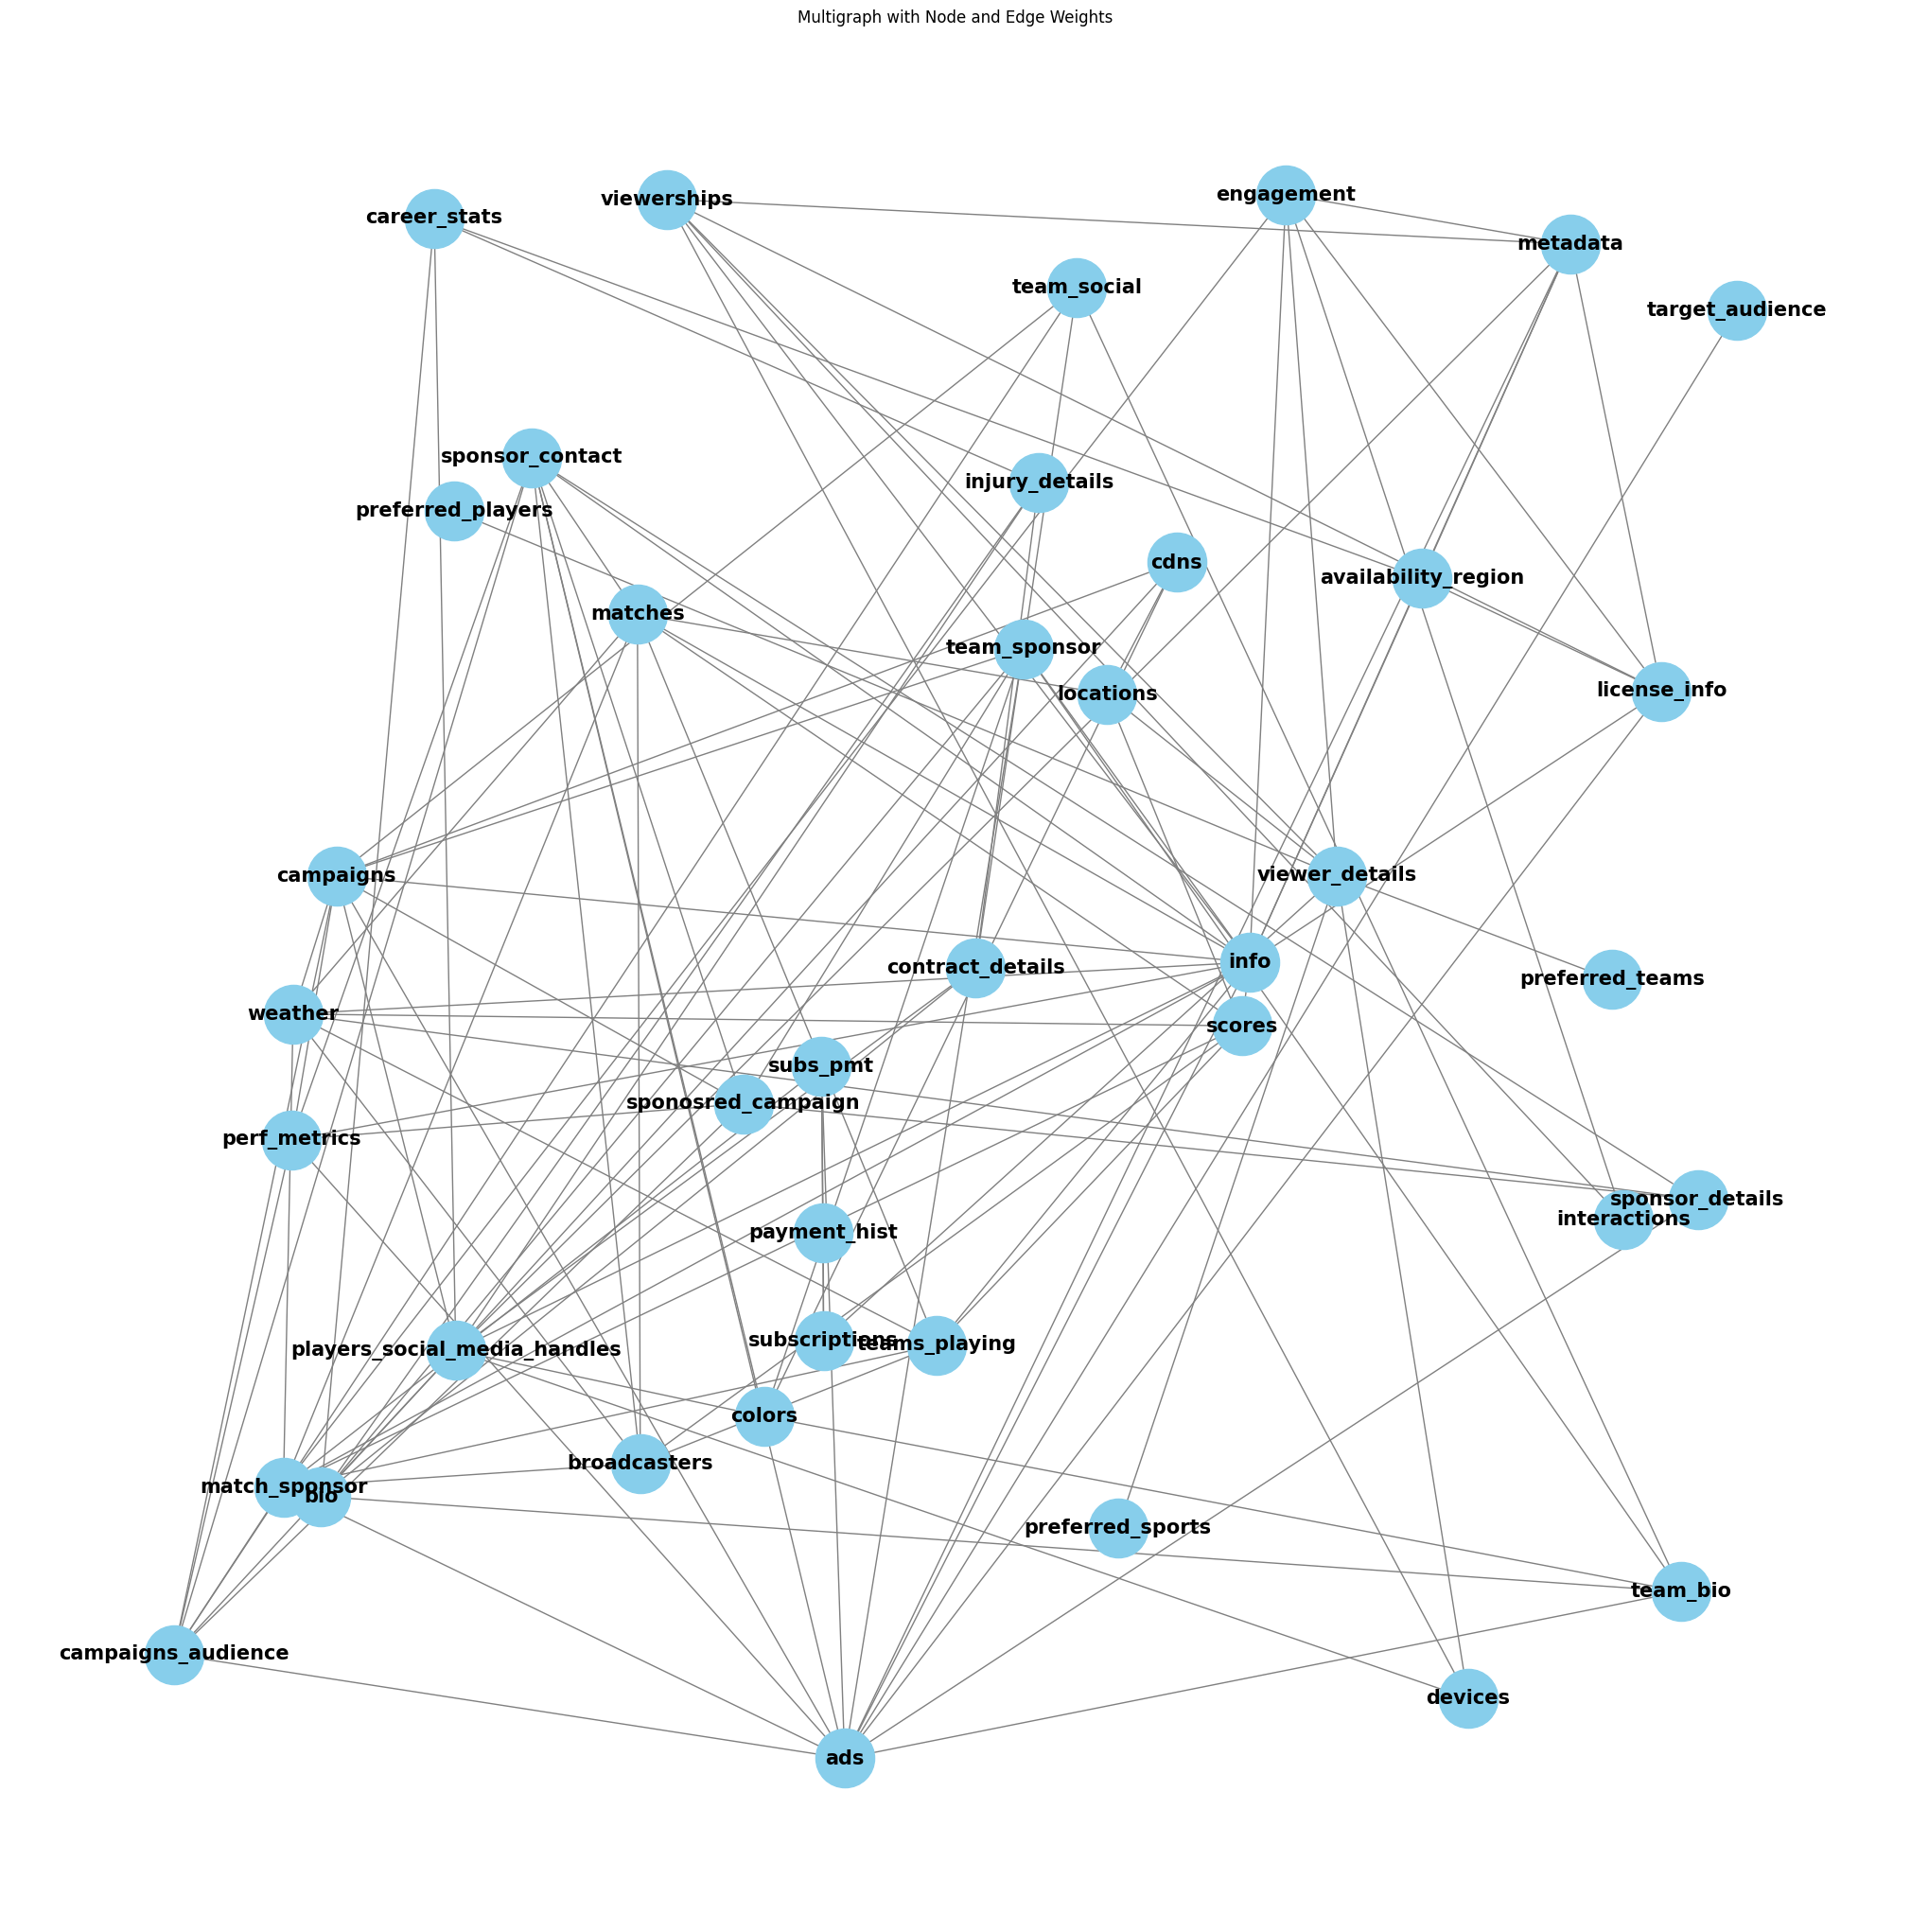

In [6]:
sm.visualize()  # To visualize the relationships as a graph

## 4. The Semantic Layer

The SemanticModel results are used to generate YAML files which are saved automatically. These files defines the semantic layer, including the models (tables) and their relationships. 

By default, these files are saved in the current working directory. You can configure this path by setting the `PROJECT_BASE` environment variable.

## 5. Semantic Search

The semantic search feature allows you to search for columns in your datasets using natural language. 

> **Note:** To use this feature, you need to have a running Qdrant instance and an OpenAI API key. Please refer to the [README.md](README.md) for detailed setup instructions.
>
> **Google Colab Users:** If you are running this notebook in Google Colab, you may not be able to connect to a local Qdrant instance running in Docker. In this case, you will need to use a remotely hosted Qdrant server.
>
> **Current Limitation:** Currently, the semantic search feature requires an OpenAI or Azure OpenAI key as it is tightly coupled with Ada embeddings. We are actively working on decoupling this.

Once you have built the semantic model, you can use the `search` method to perform a semantic search. The search function returns a pandas DataFrame containing the search results, including the column's profiling metrics, category, table name, and table glossary.

In [7]:
# Perform a semantic search
search_results = sm.search("viewer satisfaction")

# View the search results
search_results

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/semantic_search/semantic_search.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_embedding_result_glossary["score"] = late_embedding_result_glossary["score"] / len(late_vector)


,column_id,score,relevancy,column_name,column_glossary,column_tags,category,table_name,table_glossary,uniqueness,completeness,count,null_count,distinct_count,sample_data
0,viewerships.QualityOfExperience,0.999998,RelevancyCate,QualityOfExperience,Measures the perceived satisfaction level of v...,"[Viewer Satisfaction, User Experience Metrics,...",dimension,viewerships,Tracks viewer engagement and content consumpti...,0.003,1.0,1000,0,3,"[Poor, Good, Excellent]"
1,viewer_details.LocationID,0.892650,RelevancyCate,LocationID,Identifies the geographical area associated wi...,"[Geographic Identifier, Viewer Location, Regio...",dimension,viewer_details,"Captures demographic, subscription, and activi...",0.100,1.0,1000,0,100,"[79, 90, 66, 82, 25, 9, 86, 29, 93, 56]"
2,subscriptions.SubscriptionTier,0.873580,RelevancyCate,SubscriptionTier,Indicates the level of service or benefits ass...,"[Customer Segmentation, Subscription Plan, Rev...",dimension,subscriptions,"Tracks viewer subscription details, including ...",0.006,1.0,500,0,3,"[Premium, Basic, Standard]"
3,sponsor_contact.Phone,0.870823,RelevancyCate,Phone,Facilitates communication with sponsors by sto...,"[Sponsor Communication, Contact Information, B...",dimension,sponsor_contact,"Stores contact information for sponsors, inclu...",1.000,1.0,50,0,50,"[859.629.7290x68472, (819)789-7247x74588, 809...."
4,viewer_details.LastLogin,0.869735,RelevancyCate,LastLogin,Tracks the most recent time a viewer accessed ...,"[User Engagement Tracking, Login Activity Moni...",dimension,viewer_details,"Captures demographic, subscription, and activi...",1.000,1.0,1000,0,1000,"[2024-02-23 14:27:45, 2024-03-31 20:41:54, 202..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,colors.TeamID,0.800645,Relevanc,TeamID,Identifies the organization or group associate...,"[Team Identification, Sports Team Reference, E...",dimension,colors,Defines the visual identity of teams through t...,0.500,1.0,100,0,50,"[24, 45, 42, 20, 22, 30, 50, 10, 44, 32]"
202,cdns.Region,0.799404,RelevancyCate,Region,Defines the geographical area associated with ...,"[Geographical Location, Content Distribution, ...",dimension,cdns,Manages information about content delivery net...,0.060,1.0,50,0,3,"[North America, Europe, Asia]"
203,subs_pmt.Currency,0.797583,RelevancyCate,Currency,Denotes the type of monetary unit used for sub...,"[Subscription Payment, Monetary Unit, Internat...",dimension,subs_pmt,Tracks payment transactions associated with su...,0.006,1.0,500,0,3,"[EUR, USD, GBP]"
204,ads.AdID,0.797155,RelevancyCate,AdID,Uniquely identifies advertisements within the ...,"[Advertisement Identifier, Campaign Tracking, ...",dimension,ads,"Tracks advertisements, including their type, d...",1.000,1.0,200,0,200,"[171, 10, 138, 147, 35, 73, 188, 182, 196, 111]"


## 6. Data Product Creation

The semantic layer serves as a foundation for the DataProduct, which streamlines the creation of reusable data products. This allows you
to encapsulate business logic and create standardized, trustworthy data assets that can be easily shared and reused across different teams and 
applications.

Let's define the model for the data product we want to build:

In [8]:
data_product_config = \
{
  "name": "at_risk_high_value_viewers",
  "fields": [
    {"id": "viewer_details.FirstName", "name": "first_name"},
    {"id": "viewer_details.Email", "name": "email"},
    {
      "id": "viewerships.TotalWatchTime",
      "name": "total_watch_time",
      "category": "measure",
         "measure_func": "sum"
       }
     ],
     "filter": {
       "selections": [
         {
           "id": "viewerships.QualityOfExperience",
           "values": ["Poor"]
         }
       ],
       "sort_by": [
         {
           "id": "viewerships.TotalWatchTime",
           "alias": "total_watch_time",
           "direction": "desc"
         }
       ],
       "limit": 50
     }
   }


Now, let's use the `DataProduct` to generate the data product:

In [9]:
from intugle import DataProduct

# Create a DataProduct
dp = DataProduct()

# Generate the data product
data_product = dp.build(data_product_config)

data_product.to_df()

Found existing YAML for 'team_social'. Checking for staleness.
team_social loaded
Found existing YAML for 'contract_details'. Checking for staleness.
contract_details loaded
Found existing YAML for 'subscriptions'. Checking for staleness.
subscriptions loaded
Found existing YAML for 'sponsor_contact'. Checking for staleness.
sponsor_contact loaded
Found existing YAML for 'engagement'. Checking for staleness.
engagement loaded
Found existing YAML for 'scores'. Checking for staleness.
scores loaded
Found existing YAML for 'bio'. Checking for staleness.
bio loaded
Found existing YAML for 'interactions'. Checking for staleness.
interactions loaded
Found existing YAML for 'sponosred_campaign'. Checking for staleness.
sponosred_campaign loaded
Found existing YAML for 'locations'. Checking for staleness.
locations loaded
Found existing YAML for 'payment_hist'. Checking for staleness.
payment_hist loaded
Found existing YAML for 'weather'. Checking for staleness.
weather loaded
Found existing Y

,first_name,email,total_watch_time
0,Matthew,hdavis@example.org,424.0
1,Brian,fdavis@example.com,396.0
2,Mary,ibarnes@example.org,332.0
3,Daniel,jmartinez@example.org,322.0
4,Steven,castanedajesse@example.org,319.0
5,Mary,kerri82@example.org,318.0
6,Matthew,amurillo@example.org,318.0
7,Karina,uhall@example.net,315.0
8,Philip,lauren04@example.net,312.0
9,Kristin,robert76@example.net,311.0


The `build` function returns a `DataSet` object. You can also view the generated SQL query used for creating the data product:

In [10]:
# The generated SQL query
data_product.sql_query

'SELECT "viewer_details"."FirstName" as first_name, "viewer_details"."Email" as email, sum("viewerships"."TotalWatchTime") as total_watch_time FROM viewerships LEFT JOIN viewer_details ON "viewer_details"."ViewerID" = "viewerships"."ViewerID" WHERE ("viewerships"."QualityOfExperience" IN (\'Poor\',)) GROUP BY "viewer_details"."FirstName" , "viewer_details"."Email" ORDER BY total_watch_time DESC LIMIT 50'

## Conclusion

You've learned how to:

*   Configure your LLM provider and Embeddings provider.
*   Build a semantic model using the `SemanticModel`.
*   Access enriched metadata, business glossaries and visualize the relationships between your tables.
*   Perform semantic search on your semantic model.
*   Generate data products from the semantic layer using the `DataProduct`.

This is just a starting point. This project has many other features to explore. We encourage you to try it with your own data and see how it can help you build a powerful semantic layer.